Goal - explore LEACE, and produce an efficient implementation function


end goal:
1. LEACE

Using device: cuda
Generated data shape: torch.Size([500, 5])
Covariance matrix:
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2500, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1111, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0625, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0400]], device='cuda:0')


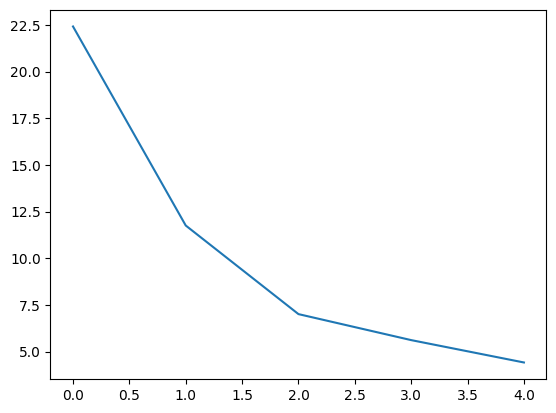

In [5]:
import torch
import torch

def generate_powerlaw_gaussian_dataset(n_samples, n_features, mean = None, alpha=2.0, epsilon=1e-5, device=torch.device("cpu"), seed=42):
    """
    Generates a Gaussian dataset with a power law diminishing covariance matrix.
    
    """

    # Set the random seed for reproducibility
    torch.manual_seed(seed)
    
    # Create a vector of variances that decay with power law.
    # Variance for feature i: 1/(i+1)^alpha + epsilon
    indices = torch.arange(1, n_features + 1, dtype=torch.float32, device=device)
    variances = 1.0 / (indices ** alpha) + epsilon
    
    # Build the diagonal covariance matrix
    cov_matrix = torch.diag(variances)
    
    # Define the zero mean for all features
    if mean is None:
        mean = torch.zeros(n_features, device=device)
    elif type(mean) == float:
        # mean is a float, create a mean vector of the same value
        mean = torch.ones(n_features, device=device) * mean


    
    # Create the multivariate normal distribution and sample data
    distribution = torch.distributions.MultivariateNormal(mean, covariance_matrix=cov_matrix)
    data = distribution.sample((n_samples,))
    
    return data, cov_matrix
# Example usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

n_samples = 500

n_features = 5
alpha = 2  # Adjust alpha to change the rate of decay

# Generate the dataset and obtain the covariance matrix used
data, cov_matrix = generate_powerlaw_gaussian_dataset(n_samples, n_features, alpha=alpha, device=device, mean = 2.)

print("Generated data shape:", data.shape)
print("Covariance matrix:\n", cov_matrix)

# Compute the empirical covariance matrix of the generated data for verification
data_centered = data - data.mean(dim=0, keepdim=True)
emp_cov = torch.mm(data_centered.t(), data_centered) / (n_samples - 1)

# Print the empirical covariance matrix
U, S, V = torch.svd(data_centered)
# plot S
import matplotlib.pyplot as plt
plt.plot(S.cpu().numpy())
plt.show()

In [6]:
import torch
import matplotlib.pyplot as plt

def plot_top2_pcs_torch(data, title="Projection onto Top 2 Principal Components", labels=None):
    """
    Computes the top two principal components using PyTorch and plots the data
    projected onto these components.
    """
    # Center the data (zero mean)
    data_centered = data - data.mean(dim=0, keepdim=True)
    
    # Compute the covariance matrix (n_features x n_features)
    n_samples = data_centered.shape[0]
    cov_matrix = torch.mm(data_centered.T, data_centered) / (n_samples - 1)
    
    # Eigen-decomposition of the covariance matrix (eigenvalues in ascending order)
    eigenvalues, eigenvectors = torch.linalg.eigh(cov_matrix)
    
    # Select the top 2 eigenvectors (columns corresponding to the largest eigenvalues)
    top2_eigenvectors = eigenvectors[:, -2:]  # shape: (n_features, 2)
    
    # Project the centered data onto the top 2 principal components
    projected_data = torch.mm(data_centered, top2_eigenvectors)  # shape: (n_samples, 2)
    
    # Convert to numpy arrays for plotting (ensure data is on CPU)
    projected_np = projected_data.cpu().numpy()
    if labels is not None:
        if isinstance(labels, torch.Tensor):
            labels_np = labels.cpu().numpy()
        else:
            labels_np = labels
    else:
        labels_np = None
    
    # Plot the data
    plt.figure(figsize=(8, 6))
    if labels_np is None:
        plt.scatter(projected_np[:, 0], projected_np[:, 1], alpha=0.7)
    else:
        scatter = plt.scatter(projected_np[:, 0], projected_np[:, 1],
                              c=labels_np, cmap='viridis', alpha=0.7)
        plt.colorbar(scatter, label="Labels")
    
    # make xlim and ylim equal
    x_max = projected_np[:, 0].max()
    x_min = projected_np[:, 0].min()
    y_max = projected_np[:, 1].max()
    y_min = projected_np[:, 1].min()
    max_ = max(abs(x_max), abs(x_min), abs(y_max), abs(y_min))
    min_ = min(abs(x_max), abs(x_min), abs(y_max), abs(y_min))
    plt.xlim(-max_, max_)
    plt.ylim(-max_, max_)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title(title)
    plt.grid(True)
    plt.show()


Using device: cuda
X shape: torch.Size([1000, 2])
Covariance of the whitened data:
 tensor([[9.9999e-01, 8.3100e-06],
        [8.3100e-06, 9.9998e-01]], device='cuda:0')


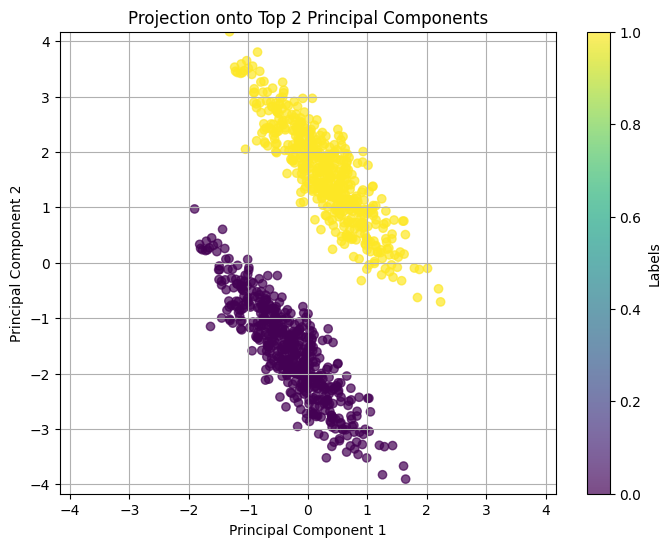

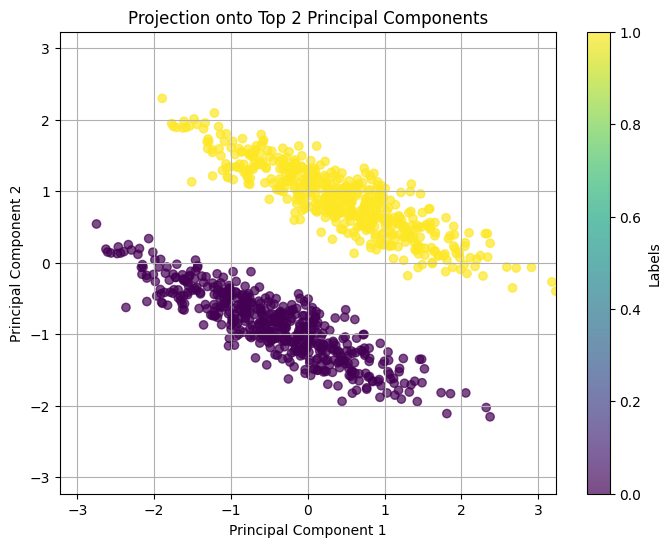

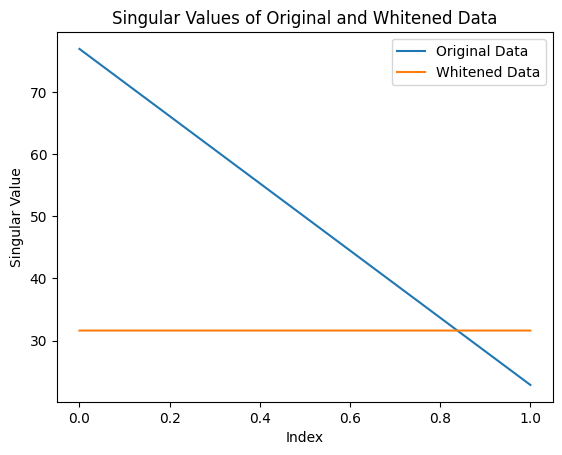

In [7]:
import torch

def whiten_data_torch(X, epsilon=1e-5):
    """
    Whitens the dataset X using eigenvalue decomposition in PyTorch.
    
    The input X should be a tensor of shape (n_samples, n_features). The function centers
    the data and applies the whitening transform so that the output has an (approximately)
    identity covariance matrix.
    
    Parameters:
    - X : torch.Tensor
          Input data of shape (n_samples, n_features).
    - epsilon : float, optional
          Small constant added for numerical stability.
    
    Returns:
    - X_whitened : torch.Tensor
          The whitened data with approximately unit covariance.
    """
    # Center the data (zero mean)
    X_centered = X - torch.mean(X, dim=0, keepdim=True)
    
    # Compute the covariance matrix: (n_features x n_features)
    n_samples = X_centered.size(0)
    cov = torch.mm(X_centered.T, X_centered) / (n_samples - 1)
    
    # Eigen-decomposition of the covariance matrix
    eigenvalues, eigenvectors = torch.linalg.eigh(cov)
    
    # Create the diagonal matrix for the inverse square root of eigenvalues
    D_inv = torch.diag(1.0 / torch.sqrt(eigenvalues + epsilon))
    
    # Compute the whitening matrix
    whitening_matrix = torch.mm(eigenvectors, torch.mm(D_inv, eigenvectors.T))
    
    # Apply the whitening transformation
    X_whitened = torch.mm(X_centered, whitening_matrix)
    
    return X_whitened

# Select device: use CUDA if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Create a random dataset with 100 samples and 5 features on the selected device
torch.manual_seed(42)

n_samples = 500
n_features = 2
alpha = 4  # Adjust alpha to change the rate of decay

# Generate the dataset and obtain the covariance matrix used
X1, cov_matrix = generate_powerlaw_gaussian_dataset(n_samples, n_features, alpha=alpha, device=device)
X2, cov_matrix = generate_powerlaw_gaussian_dataset(n_samples, n_features, alpha=alpha, device=device, mean = 2.3)

data = torch.cat((X1, X2), dim=0)

labels = torch.zeros(len(data), dtype=torch.long)
labels[len(X1):] = 1

print(f"X shape: {data.shape}")    
# Whiten the dataset
X_white = whiten_data_torch(data)

# Verify that the covariance of the whitened data is approximately the identity matrix
n_samples = X_white.size(0)
cov_whitened = torch.mm(X_white.T, X_white) / (n_samples - 1)
print("Covariance of the whitened data:\n", cov_whitened)

# Optionally, generate some dummy labels (e.g., for binary classes)
#labels = torch.randint(0, 2, (n_samples,), device=device)

# plot original data with top pcs

plot_top2_pcs_torch(data, labels=labels)

# plot whitened data
plot_top2_pcs_torch(X_white, labels=labels)
# plot the covariance matrix of the whitened data
U, S, V = torch.svd(data)
U_whitened, S_whitened, V_whitened = torch.svd(X_white)     
plt.plot(S.cpu().numpy(), label='Original Data')
plt.plot(S_whitened.cpu().numpy(), label='Whitened Data')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.title('Singular Values of Original and Whitened Data')
plt.legend()
plt.show()


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

# Create a simple synthetic dataset
# We'll create two clusters in 2D space:
# - Cluster for class 0 centered at (-1, -1)
# - Cluster for class 1 centered at (1, 1)
torch.manual_seed(42)

y= labels
dim = data.shape[1]

# Define the Logistic Regression model
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)  # single output for binary classification

    def forward(self, x):
        # Apply linear transformation followed by a sigmoid activation
        x= x.float()
        return torch.sigmoid(self.linear(x))

# x to float
X = data.float()
labels = labels.float()
model = LogisticRegression(dim)
# model to device
model.to(device)
labels = labels.to(device)
X = X.to(device)
# Define the loss function and the optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass: compute predicted y by passing X to the model
    outputs = model(X).squeeze()  # squeeze to remove extra dimensions
    loss = criterion(outputs, y)
    
    # Zero gradients, perform backward pass, and update weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the trained model
with torch.no_grad():
    predictions = (model(X).squeeze() >= 0.5).float()  # threshold at 0.5 for binary classification
    accuracy = (predictions == y).float().mean()
    print(f'Accuracy: {accuracy.item() * 100:.2f}%')


RuntimeError: Found dtype Long but expected Float

In [30]:
data.shape

torch.Size([1000, 2])

Epoch [100/1000], Loss: 0.1807
Epoch [200/1000], Loss: 0.1054
Epoch [300/1000], Loss: 0.0742
Epoch [400/1000], Loss: 0.0572
Epoch [500/1000], Loss: 0.0467
Epoch [600/1000], Loss: 0.0395
Epoch [700/1000], Loss: 0.0343
Epoch [800/1000], Loss: 0.0303
Epoch [900/1000], Loss: 0.0272
Epoch [1000/1000], Loss: 0.0246
Weights: [0.60254776 3.1632836 ], Bias: -3.764364004135132


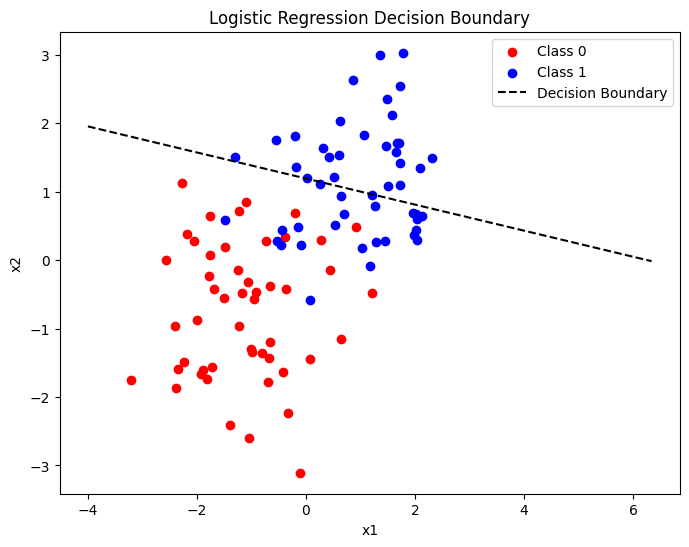

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Generate synthetic dataset
N = 100  # total number of samples
D = 2    # number of features

# Data for class 0 and class 1
x0 = torch.randn(N // 2, D) - 1  # Class 0
x1 = torch.randn(N // 2, D) + 1  # Class 1
X = torch.cat([x0, x1], dim=0)
y = torch.cat([torch.zeros(N // 2), torch.ones(N // 2)], dim=0)

X = data.cpu()
y = labels.cpu()
# Define logistic regression model
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

model = LogisticRegression(D)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    outputs = model(X).squeeze()
    loss = criterion(outputs, y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Extract the weights and bias from the trained model
with torch.no_grad():
    w = model.linear.weight[0]  # weights for the two features
    b = model.linear.bias.item()  # bias

# Detach the weight tensor before converting it to a numpy array
print(f"Weights: {w.detach().numpy()}, Bias: {b}")
# Compute decision boundary: w1*x1 + w2*x2 + b = 0 --> x2 = -(w1/w2)*x1 - (b/w2)
# We generate x1 values across a range covering our dataset.
x1_vals = torch.linspace(X[:, 0].min()-1, X[:, 0].max()+1, 100)
if w[1] != 0:
    w = w.detach()
    
    x2_vals = -(w[0]/w[1]) * x1_vals - (b/w[1])
else:
    # In case w[1] is zero, plot a vertical line at -b/w[0]
    x1_boundary = -b/w[0]
    x1_vals = torch.full((100,), x1_boundary)
    x2_vals = torch.linspace(X[:, 1].min()-1, X[:, 1].max()+1, 100)

# Plotting the data and the decision boundary
plt.figure(figsize=(8,6))
# Plot class 0 points
plt.scatter(x0[:, 0].numpy(), x0[:, 1].numpy(), color='red', label='Class 0')
# Plot class 1 points
plt.scatter(x1[:, 0].numpy(), x1[:, 1].numpy(), color='blue', label='Class 1')
# Plot decision boundary
plt.plot(x1_vals.detach().numpy(), x2_vals.detach().numpy(), 'k--', label='Decision Boundary')

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Logistic Regression Decision Boundary')
plt.legend()
plt.show()
